# ニューラルネットワーク

処理の流れ

正解ラベルの作成 → 学習データと検証データに分割 → 学習

まず学習データを用いて学習させ、得られた機械学習モデルに検証データを入れて出力（pred_data）を作り、検証データ（y_test）と照合することで精度を求めます。

ここでは Tensorflow-Keras を使い、全結合型モデルによる2値分類および4値分類、CNNモデルによる4値分類を行います。

In [ ]:
import os
from google.colab import drive

# googleドライブのマウント 
drive.mount('/content/drive/')

# ネットワーク図を収納するフォルダを作成
if os.path.exists('/content/drive/My Drive/data/network') == False:
  os.makedirs('/content/drive/My Drive/data/network')

# 作業ファイルをマイドライブに変更
os.chdir('/content/drive/My Drive/') 

Mounted at /content/drive/


In [ ]:
# MeCab-TFIDFで作成済みの文書データ、ラベル、4分割用インデックスの読み込み
from scipy.io import mmread
from scipy.sparse import csr_matrix
import numpy as np

x_ = mmread('data/mecab_TfIdf_csr.mtx')
x_ = csr_matrix(x_)
y_2 = np.load('data/y_2category.npy')
y_4 = np.load('data/y_4category.npy').astype('float64')
div_index = np.load('data/index.npy', allow_pickle=True)


### CNN4値分類モデル

ウインドウサイズ2,3,4,5のフィルターを持つ4枚の1次元CNN層、ドロップアウト層、プーリング層を入れ、それをconcat層でまとめています。

フレームワークはTensorflow-Kerasを使用しました。

In [ ]:
# CNN（4filters）1層4値分類モデル
%tensorflow_version 2.x
import tensorflow as tf
print('tf.version', tf.__version__)
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Conv1D, Activation
from tensorflow.keras.layers import SpatialDropout1D, MaxPooling1D, Concatenate, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from tensorflow.keras import losses
import matplotlib.pyplot as plt
from PIL import Image
from IPython.core.display import display
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

def plot_quad_history(trend): #  3回データを逐次投入するとき
  import matplotlib.pyplot as plt
  %matplotlib inline
  fig = plt.figure(figsize=(8.0, 6.0))
  ax1 = fig.add_subplot(2, 2, 1)
  ax2 = fig.add_subplot(2, 2, 2)
  ax3 = fig.add_subplot(2, 2, 3)
  ax4 = fig.add_subplot(2, 2, 4)
  ax1.plot(range(1, len(trend.history['out_0_acc'])+1), trend.history['out_0_acc'], label='acc_0')
  ax2.plot(range(1, len(trend.history['out_1_acc'])+1), trend.history['out_1_acc'], label='acc_1')
  ax3.plot(range(1, len(trend.history['out_2_acc'])+1), trend.history['out_2_acc'], label='acc_2')
  ax4.plot(range(1, len(trend.history['out_3_acc'])+1), trend.history['out_3_acc'], label='acc_3')
  ax1.plot(range(1, len(trend.history['out_0_loss'])+1), trend.history['out_0_loss'], label='loss_0')
  ax2.plot(range(1, len(trend.history['out_1_loss'])+1), trend.history['out_1_loss'], label='loss_1')
  ax3.plot(range(1, len(trend.history['out_2_loss'])+1), trend.history['out_2_loss'], label='loss_2')
  ax4.plot(range(1, len(trend.history['out_3_loss'])+1), trend.history['out_3_loss'], label='loss_3')
  ax1.plot(range(1, len(trend.history['val_out_0_acc'])+1), trend.history['val_out_0_acc'], label='val_acc_0')
  ax2.plot(range(1, len(trend.history['val_out_1_acc'])+1), trend.history['val_out_1_acc'], label='val_acc_1')
  ax3.plot(range(1, len(trend.history['val_out_2_acc'])+1), trend.history['val_out_2_acc'], label='val_acc_2')
  ax4.plot(range(1, len(trend.history['val_out_3_acc'])+1), trend.history['val_out_3_acc'], label='val_acc_3')
  ax1.plot(range(1, len(trend.history['val_out_0_loss'])+1), trend.history['val_out_0_loss'], label='val_loss_0')
  ax2.plot(range(1, len(trend.history['val_out_1_loss'])+1), trend.history['val_out_1_loss'], label='val_loss_1')
  ax3.plot(range(1, len(trend.history['val_out_2_loss'])+1), trend.history['val_out_2_loss'], label='val_loss_2')
  ax4.plot(range(1, len(trend.history['val_out_3_loss'])+1), trend.history['val_out_3_loss'], label='val_loss_3')
  ax1.legend()
  ax2.legend()
  ax3.legend()
  ax4.legend()
  plt.xlabel('epoch')
  plt.ylabel('loss/acc')
  plt.show()


def DrctIn_4FLConv1D_4pthOut(x, No):
  inputs = Input(shape=x.shape[1])
  h = Reshape((x.shape[1], 1), input_shape=(x.shape[1],))(inputs)
  h2 = Conv1D(8, 2, activation='relu')(h)
  h2 = SpatialDropout1D(0.2)(h2)
  h2 = MaxPooling1D(3)(h2)
  h3 = Conv1D(8, 3, activation='relu')(h)
  h3 = SpatialDropout1D(0.2)(h3)
  h3 = MaxPooling1D(3)(h3)
  h4 = Conv1D(8, 4, activation='relu')(h)
  h4 = SpatialDropout1D(0.2)(h4)
  h4 = MaxPooling1D(3)(h4)
  h5 = Conv1D(8, 5, activation='relu')(h)
  h5 = SpatialDropout1D(0.2)(h5)
  h5 = MaxPooling1D(3)(h5)
  h = Concatenate(axis=1)([h2, h3, h4, h5])
  h = Flatten()(h)
  h = Dense(512, activation='relu')(h)
  h0 = Dense(16, activation='relu')(h)
  h1 = Dense(16, activation='relu')(h)
  h2 = Dense(16, activation='relu')(h)
  h3 = Dense(16, activation='relu')(h)
  out_0 = Dense(1, activation='sigmoid', name='out_0')(h0)
  out_1 = Dense(1, activation='sigmoid', name='out_1')(h1)
  out_2 = Dense(1, activation='sigmoid', name='out_2')(h2)
  out_3 = Dense(1, activation='sigmoid', name='out_3')(h3)

  model = Model(inputs=inputs, outputs=[out_0, out_1, out_2, out_3])
  # 生成したネットワーク図の表示
  if No == 0:
    print()
    model.summary()
    plot_model(model, 
              to_file='data/network/DrctIn_4fCNN1_4dOut.png', 
              show_shapes=True)
  im = Image.open('data/network/DrctIn_4fCNN1_4dOut.png')
  im_resize = im.resize(size=(int(im.width*coef), int(im.height*coef)))
  display(im_resize)

  return model


tf.version 2.3.0


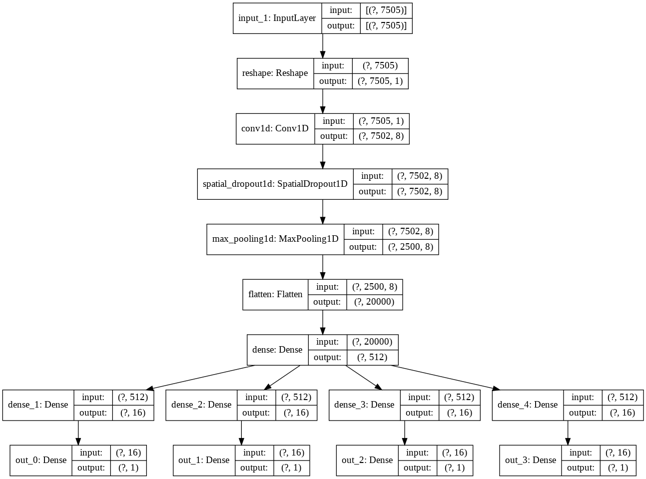

In [ ]:
plot_model(model, 
          to_file='data/network/DrctIn_4fCNN1_4dOut.png', 
          show_shapes=True)
im = Image.open('data/network/DrctIn_4fCNN1_4dOut.png')
im_resize = im.resize(size=(int(im.width*coef), int(im.height*coef)))
display(im_resize)


学習12回目


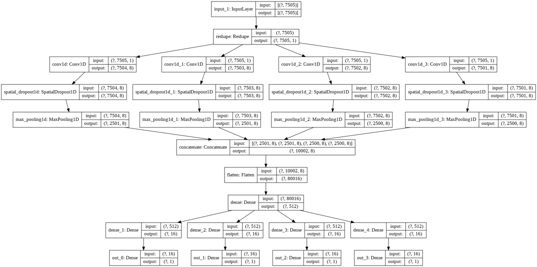

Epoch 1/12
106/106 [==============================] - 2s 20ms/step - loss: 0.2819 - out_0_loss: 0.0555 - out_1_loss: 0.0745 - out_2_loss: 0.0638 - out_3_loss: 0.0881 - out_0_acc: 0.9283 - out_1_acc: 0.9088 - out_2_acc: 0.9209 - out_3_acc: 0.8874 - val_loss: 0.1726 - val_out_0_loss: 0.0328 - val_out_1_loss: 0.0440 - val_out_2_loss: 0.0483 - val_out_3_loss: 0.0475 - val_out_0_acc: 0.9597 - val_out_1_acc: 0.9419 - val_out_2_acc: 0.9153 - val_out_3_acc: 0.9467
Epoch 2/12
106/106 [==============================] - 2s 17ms/step - loss: 0.1203 - out_0_loss: 0.0219 - out_1_loss: 0.0324 - out_2_loss: 0.0353 - out_3_loss: 0.0307 - out_0_acc: 0.9698 - out_1_acc: 0.9588 - out_2_acc: 0.9511 - out_3_acc: 0.9618 - val_loss: 0.1586 - val_out_0_loss: 0.0313 - val_out_1_loss: 0.0395 - val_out_2_loss: 0.0407 - val_out_3_loss: 0.0471 - val_out_0_acc: 0.9579 - val_out_1_acc: 0.9461 - val_out_2_acc: 0.9538 - val_out_3_acc: 0.9336
Epoch 3/12
106/106 [==============================] - 2s 17ms/step - loss: 0.0

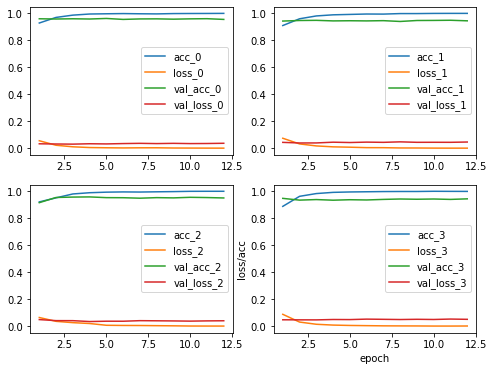

推論12回目
53/53 [==============================] - 0s 4ms/step
未知データ推論，正答率：88.626%

acc平均: 88.764%


In [ ]:
# CNN層4値分類モデル(単純交差検証)

# 定数
index_cycle = [[[0, 1], 2, 3], [[0, 1], 3, 2], 
               [[0, 2], 1, 3], [[0, 2], 3, 1], 
               [[0, 3], 1, 2], [[0, 3], 2, 1], 
               [[1, 2], 0, 3], [[1, 2], 3, 0], 
               [[1, 3], 0, 2], [[1, 3], 2, 0], 
               [[2, 3], 0, 1], [[2, 3], 1, 0]
               ]
               
loss, optimizer, metrics = ['mean_squared_error', 'Adam', 'acc']
batch_size = 32
epochs = 12
coef = 0.5
Trsld = 0.5

ref = [[], [], []]
result = []
for i, cond in enumerate(index_cycle):
  initial_epoch = 0
  clear_output()
  print('学習{}回目'.format(i+1))
  model = DrctIn_4FLConv1D_4pthOut(x_, i)
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  train_, valid_, test_ = cond
  train_index = np.hstack([div_index[train_[0]], div_index[train_[1]]])
  x_train = x_[train_index].todense()
  y_train = y_4[train_index]
  valid_index = div_index[valid_]
  x_valid = x_[valid_index].todense()
  y_valid = y_4[valid_index]
  test_index = div_index[test_]
  x_test = x_[test_index].todense()
  y_test = y_4[test_index]

  # 学習
  temp = model.fit(x_train, {'out_0':y_train[:,0], 'out_1':y_train[:,1], 
                                'out_2':y_train[:,2], 'out_3':y_train[:,3]}, 
                      batch_size=batch_size, 
                      initial_epoch=initial_epoch, epochs=initial_epoch+epochs, verbose=1, 
                      validation_data=(x_valid, {'out_0':y_valid[:,0], 'out_1':y_valid[:,1], 
                                                  'out_2':y_valid[:,2], 'out_3':y_valid[:,3]}))
  training = temp

  # 学習曲線のプロット
  plot_quad_history(training)
  # 未知データを入力して正答率を求める
  print('推論{}回目'.format(i+1))
  pred_data = model.predict(x_test, batch_size=batch_size, verbose=1, steps=None)
  # Tensorflow graphの消去
  tf.keras.backend.clear_session()
  # 正答率計算
  pred_data = np.argmax(np.hstack(pred_data), axis=1)
  y_test = np.argmax(y_test, axis=1)
  accuracy = accuracy_score(pred_data, y_test)
  result.append(accuracy)
  print('未知データ推論，正答率：{0:.3%}\n'.format(accuracy))
  ref[0] += test_index.tolist()
  ref[1] += pred_data.tolist()
  ref[2] += y_test.tolist()

print('acc平均: {0:.3%}'.format(sum(result)/len(result)))
# 各カテゴリの正答率をExcelとして出力
pd.DataFrame(ref).T.to_excel('data/ref.xlsx', header=None, index=None)

### 全結合層４値分類モデル

CNN層を使わず全結合層だけでモデルを組んでみます

In [ ]:
def DrctIn_Dense_4pthOut(x, No):
  inputs = Input(shape=x.shape[1])
  #h = Reshape((x.shape[1], 1), input_shape=(x.shape[1],))(inputs)
  #h2 = Conv1D(8, 2, activation='relu')(h)
  #h2 = SpatialDropout1D(0.2)(h2)
  #h2 = MaxPooling1D(3)(h2)
  #h3 = Conv1D(8, 3, activation='relu')(h)
  #h3 = SpatialDropout1D(0.2)(h3)
  #h3 = MaxPooling1D(3)(h3)
  #h4 = Conv1D(8, 4, activation='relu')(h)
  #h4 = SpatialDropout1D(0.2)(h4)
  #h4 = MaxPooling1D(3)(h4)
  #h5 = Conv1D(8, 5, activation='relu')(h)
  #h5 = SpatialDropout1D(0.2)(h5)
  #h5 = MaxPooling1D(3)(h5)
  #h = Concatenate(axis=1)([h2, h3, h4, h5])
  #h = Flatten()(h)
  h = Dense(512, activation='relu')(inputs)#(h)
  h0 = Dense(16, activation='relu')(h)
  h1 = Dense(16, activation='relu')(h)
  h2 = Dense(16, activation='relu')(h)
  h3 = Dense(16, activation='relu')(h)
  out_0 = Dense(1, activation='sigmoid', name='out_0')(h0)
  out_1 = Dense(1, activation='sigmoid', name='out_1')(h1)
  out_2 = Dense(1, activation='sigmoid', name='out_2')(h2)
  out_3 = Dense(1, activation='sigmoid', name='out_3')(h3)

  model = Model(inputs=inputs, outputs=[out_0, out_1, out_2, out_3])
  # 生成したネットワーク図の表示
  if No == 0:
    print()
    model.summary()
    plot_model(model, 
              to_file='data/network/DrctIn_4fCNN1_4dOut.png', 
              show_shapes=True)
  im = Image.open('data/network/DrctIn_4fCNN1_4dOut.png')
  im_resize = im.resize(size=(int(im.width*coef), int(im.height*coef)))
  display(im_resize)

  return model

学習12回目


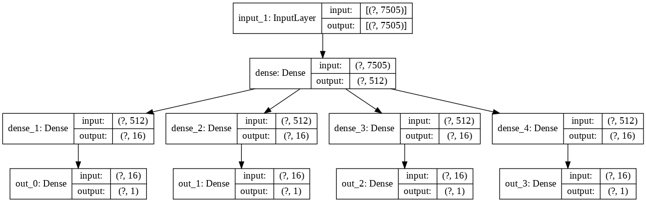

Epoch 1/12
106/106 [==============================] - 1s 11ms/step - loss: 0.3951 - out_0_loss: 0.0856 - out_1_loss: 0.0945 - out_2_loss: 0.0900 - out_3_loss: 0.1250 - out_0_acc: 0.8919 - out_1_acc: 0.8972 - out_2_acc: 0.9221 - out_3_acc: 0.8486 - val_loss: 0.2173 - val_out_0_loss: 0.0368 - val_out_1_loss: 0.0476 - val_out_2_loss: 0.0679 - val_out_3_loss: 0.0650 - val_out_0_acc: 0.9573 - val_out_1_acc: 0.9348 - val_out_2_acc: 0.9153 - val_out_3_acc: 0.9259
Epoch 2/12
106/106 [==============================] - 1s 8ms/step - loss: 0.1424 - out_0_loss: 0.0237 - out_1_loss: 0.0295 - out_2_loss: 0.0470 - out_3_loss: 0.0422 - out_0_acc: 0.9727 - out_1_acc: 0.9642 - out_2_acc: 0.9221 - out_3_acc: 0.9505 - val_loss: 0.1548 - val_out_0_loss: 0.0304 - val_out_1_loss: 0.0409 - val_out_2_loss: 0.0432 - val_out_3_loss: 0.0403 - val_out_0_acc: 0.9633 - val_out_1_acc: 0.9437 - val_out_2_acc: 0.9153 - val_out_3_acc: 0.9496
Epoch 3/12
106/106 [==============================] - 1s 8ms/step - loss: 0.072

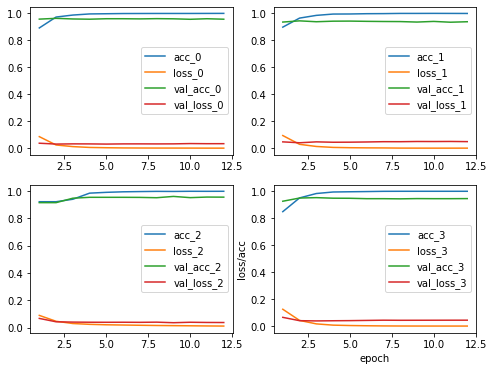

推論12回目
53/53 [==============================] - 0s 2ms/step
未知データ推論，正答率：88.981%

acc平均: 89.608%


In [ ]:
# 全結合層4値分類モデル(単純交差検証)


# 定数
index_cycle = [[[0, 1], 2, 3], [[0, 1], 3, 2], 
               [[0, 2], 1, 3], [[0, 2], 3, 1], 
               [[0, 3], 1, 2], [[0, 3], 2, 1], 
               [[1, 2], 0, 3], [[1, 2], 3, 0], 
               [[1, 3], 0, 2], [[1, 3], 2, 0], 
               [[2, 3], 0, 1], [[2, 3], 1, 0]
               ]
               
loss, optimizer, metrics = ['mean_squared_error', 'Adam', 'acc']
batch_size = 32
epochs = 12
coef = 0.5
Trsld = 0.5

ref = [[], [], []]
result = []
for i, cond in enumerate(index_cycle):
  initial_epoch = 0
  clear_output()
  print('学習{}回目'.format(i+1))
  model = DrctIn_Dense_4pthOut(x_, i)
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  train_, valid_, test_ = cond
  train_index = np.hstack([div_index[train_[0]], div_index[train_[1]]])
  x_train = x_[train_index].todense()
  y_train = y_4[train_index]
  valid_index = div_index[valid_]
  x_valid = x_[valid_index].todense()
  y_valid = y_4[valid_index]
  test_index = div_index[test_]
  x_test = x_[test_index].todense()
  y_test = y_4[test_index]

  # 学習
  temp = model.fit(x_train, {'out_0':y_train[:,0], 'out_1':y_train[:,1], 
                                'out_2':y_train[:,2], 'out_3':y_train[:,3]}, 
                      batch_size=batch_size, 
                      initial_epoch=initial_epoch, epochs=initial_epoch+epochs, verbose=1, 
                      validation_data=(x_valid, {'out_0':y_valid[:,0], 'out_1':y_valid[:,1], 
                                                  'out_2':y_valid[:,2], 'out_3':y_valid[:,3]}))
  training = temp

  # 学習曲線のプロット
  plot_quad_history(training)
  # 未知データを入力して正答率を求める
  print('推論{}回目'.format(i+1))
  pred_data = model.predict(x_test, batch_size=batch_size, verbose=1, steps=None)
  # Tensorflow graphの消去
  tf.keras.backend.clear_session()
  # 正答率計算
  pred_data = np.argmax(np.hstack(pred_data), axis=1)
  y_test = np.argmax(y_test, axis=1)
  accuracy = accuracy_score(pred_data, y_test)
  result.append(accuracy)
  print('未知データ推論，正答率：{0:.3%}\n'.format(accuracy))
  ref[0] += test_index.tolist()
  ref[1] += pred_data.tolist()
  ref[2] += y_test.tolist()

print('acc平均: {0:.3%}'.format(sum(result)/len(result)))
# 各カテゴリの正答率をExcelとして出力
pd.DataFrame(ref).T.to_excel('data/ref.xlsx', header=None, index=None)


CNN層を使うときより精度が約1%向上しました。

モデルが小さくなったことにより、学習にかかる時間が短くなりました。

### 交差検証の工夫

データを４分割したので、そのうち１つを未知（test）データを残し、

残りの３つで学習（train）データと検証（valid）データを使い回して学習に用いるデータを増やします。

学習4回目


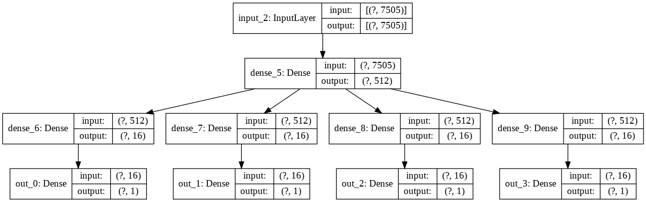

Epoch 1/4
106/106 [==============================] - 1s 10ms/step - loss: 0.4088 - out_0_loss: 0.0951 - out_1_loss: 0.0973 - out_2_loss: 0.1001 - out_3_loss: 0.1163 - out_0_acc: 0.8786 - out_1_acc: 0.9185 - out_2_acc: 0.9114 - out_3_acc: 0.8288 - val_loss: 0.2445 - val_out_0_loss: 0.0524 - val_out_1_loss: 0.0418 - val_out_2_loss: 0.0754 - val_out_3_loss: 0.0749 - val_out_0_acc: 0.9348 - val_out_1_acc: 0.9473 - val_out_2_acc: 0.9117 - val_out_3_acc: 0.8264
Epoch 2/4
106/106 [==============================] - 1s 8ms/step - loss: 0.1670 - out_0_loss: 0.0267 - out_1_loss: 0.0260 - out_2_loss: 0.0546 - out_3_loss: 0.0597 - out_0_acc: 0.9725 - out_1_acc: 0.9674 - out_2_acc: 0.9180 - out_3_acc: 0.9334 - val_loss: 0.1913 - val_out_0_loss: 0.0396 - val_out_1_loss: 0.0372 - val_out_2_loss: 0.0477 - val_out_3_loss: 0.0668 - val_out_0_acc: 0.9467 - val_out_1_acc: 0.9544 - val_out_2_acc: 0.9117 - val_out_3_acc: 0.9378
Epoch 3/4
106/106 [==============================] - 1s 8ms/step - loss: 0.1060 -

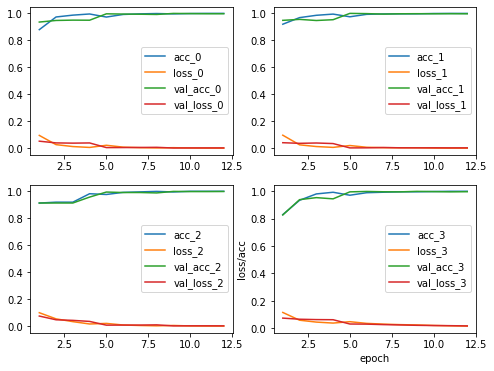

推論4回目
53/53 [==============================] - 0s 2ms/step
未知データ推論，正答率：89.396%

acc平均: 90.314%


In [ ]:
# 交差検証の工夫
# 定数
index_cycle = [[[[1, 2], 0, 3], [[0, 2], 1, 3], [[0, 1], 2, 3]], 
               [[[2, 3], 1, 0], [[1, 3], 2, 0], [[1, 2], 3, 0]], 
               [[[2, 3], 0, 1], [[0, 3], 2, 1], [[0, 2], 3, 1]], 
               [[[1, 3], 0, 2], [[0, 3], 1, 2], [[0, 1], 3, 2]]
               ]
loss, optimizer, metrics = ['mean_squared_error', 'Adam', 'acc']
batch_size = 32
epochs = 4
coef = 0.5
Trsld = 0.5

ref = [[], [], []]
result = []
for i, cond in enumerate(index_cycle):
  initial_epoch = 0
  clear_output()
  print('学習{}回目'.format(i+1))
  model = DrctIn_Dense_4pthOut(x_, i)
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  for j, [train_, valid_, test_] in enumerate(cond):
    train_index = np.hstack([div_index[train_[0]], div_index[train_[1]]])
    x_train = x_[train_index].todense()
    y_train = y_4[train_index]
    valid_index = div_index[valid_]
    x_valid = x_[valid_index].todense()
    y_valid = y_4[valid_index]
    test_index = div_index[test_]
    x_test = x_[test_index].todense()
    y_test = y_4[test_index]

    # 学習
    temp = model.fit(x_train, {'out_0':y_train[:,0], 'out_1':y_train[:,1], 
                                  'out_2':y_train[:,2], 'out_3':y_train[:,3]}, 
                        batch_size=batch_size, 
                        initial_epoch=initial_epoch, epochs=initial_epoch+epochs, verbose=1, 
                        validation_data=(x_valid, {'out_0':y_valid[:,0], 'out_1':y_valid[:,1], 
                                                    'out_2':y_valid[:,2], 'out_3':y_valid[:,3]}))
    if j == 0: 
      training = temp
    else:
      training.history['loss'] += temp.history['loss']
      training.history['val_loss'] += temp.history['val_loss']
      training.history['out_0_acc'] += temp.history['out_0_acc']
      training.history['out_0_loss'] += temp.history['out_0_loss']
      training.history['val_out_0_acc'] += temp.history['val_out_0_acc']
      training.history['val_out_0_loss'] += temp.history['val_out_0_loss']
      training.history['out_1_acc'] += temp.history['out_1_acc']
      training.history['out_1_loss'] += temp.history['out_1_loss']
      training.history['val_out_1_acc'] += temp.history['val_out_1_acc']
      training.history['val_out_1_loss'] += temp.history['val_out_1_loss']
      training.history['out_2_acc'] += temp.history['out_2_acc']
      training.history['out_2_loss'] += temp.history['out_2_loss']
      training.history['val_out_2_acc'] += temp.history['val_out_2_acc']
      training.history['val_out_2_loss'] += temp.history['val_out_2_loss']
      training.history['out_3_acc'] += temp.history['out_3_acc']
      training.history['out_3_loss'] += temp.history['out_3_loss']
      training.history['val_out_3_acc'] += temp.history['val_out_3_acc']
      training.history['val_out_3_loss'] += temp.history['val_out_3_loss']
    initial_epoch += epochs
  # 学習曲線のプロット
  plot_quad_history(training)
  # 未知データを入力して正答率を求める
  print('推論{}回目'.format(i+1))
  pred_data = model.predict(x_test, batch_size=batch_size, verbose=1, steps=None)
  # Tensorflow graphの消去
  tf.keras.backend.clear_session()
  pred_data = np.argmax(np.hstack(pred_data), axis=1)
  y_test = np.argmax(y_test, axis=1)
  accuracy = accuracy_score(pred_data, y_test)
  result.append(accuracy)
  print('未知データ推論，正答率：{0:.3%}\n'.format(accuracy))
  ref[0] += test_index.tolist()
  ref[1] += pred_data.tolist()
  ref[2] += y_test.tolist()

print('acc平均: {0:.3%}'.format(sum(result)/len(result)))
# 各カテゴリの正答率をExcelとして出力
pd.DataFrame(ref).T.to_excel('data/ref.xlsx', header=None, index=None)

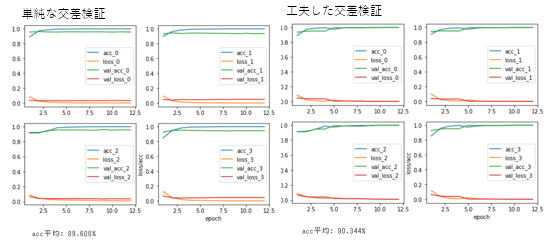

単純な交差検証に比べて教師データと検証データの乖離が少なくなり、精度も向上していることがわかります。

学習モデルは今回用いた文書ベクトルとタスクには十分適合していると考えられます。

一方、学習データには99%以上の精度があるのに対し、未知データには90%の精度しか示しません。

このようなときは、ラベルが正しく付与されているか検証する必要があります。

このデータセットの精度

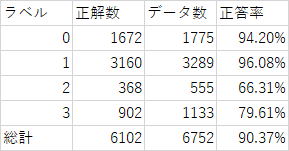

カテゴリ２（受容シート）とカテゴリ３（用途）の正答率が低くなっています。

正答率を下げている筆頭FIを割り出し、それを除去したデータに差し替えます。

### データセットの改良

In [ ]:
# MeCab-TFIDFで作成済みの文書データ、ラベル、4分割用インデックスの読み込み
from scipy.io import mmread
from scipy.sparse import csr_matrix
import numpy as np

x_ = mmread('data/改mecab_TfIdf_csr.mtx')
x_ = csr_matrix(x_)
y_4 = np.load('data/改y_4category.npy').astype('float64')
div_index = np.load('data/改index.npy', allow_pickle=True)

学習4回目


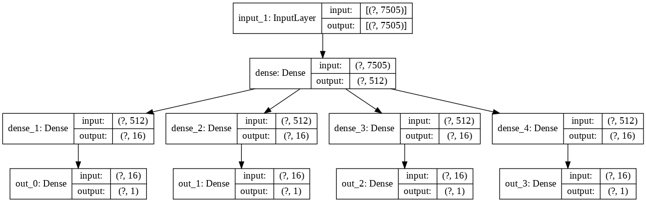

Epoch 1/4
106/106 [==============================] - 1s 11ms/step - loss: 0.3933 - out_0_loss: 0.0879 - out_1_loss: 0.0971 - out_2_loss: 0.0904 - out_3_loss: 0.1179 - out_0_acc: 0.8848 - out_1_acc: 0.9144 - out_2_acc: 0.9168 - out_3_acc: 0.8326 - val_loss: 0.2315 - val_out_0_loss: 0.0430 - val_out_1_loss: 0.0428 - val_out_2_loss: 0.0668 - val_out_3_loss: 0.0790 - val_out_0_acc: 0.9443 - val_out_1_acc: 0.9473 - val_out_2_acc: 0.9117 - val_out_3_acc: 0.8264
Epoch 2/4
106/106 [==============================] - 1s 8ms/step - loss: 0.1559 - out_0_loss: 0.0240 - out_1_loss: 0.0260 - out_2_loss: 0.0446 - out_3_loss: 0.0614 - out_0_acc: 0.9710 - out_1_acc: 0.9689 - out_2_acc: 0.9180 - out_3_acc: 0.9221 - val_loss: 0.1855 - val_out_0_loss: 0.0372 - val_out_1_loss: 0.0374 - val_out_2_loss: 0.0443 - val_out_3_loss: 0.0665 - val_out_0_acc: 0.9508 - val_out_1_acc: 0.9502 - val_out_2_acc: 0.9117 - val_out_3_acc: 0.9360
Epoch 3/4
106/106 [==============================] - 1s 8ms/step - loss: 0.1005 -

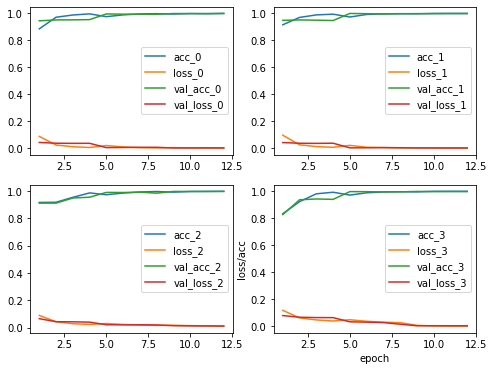

推論4回目
53/53 [==============================] - 0s 2ms/step
未知データ推論，正答率：89.810%

acc平均: 90.373%


In [ ]:
# 交差検証の工夫で用いたプログラムを変更なしに使います
# 定数
index_cycle = [[[[1, 2], 0, 3], [[0, 2], 1, 3], [[0, 1], 2, 3]], 
               [[[2, 3], 1, 0], [[1, 3], 2, 0], [[1, 2], 3, 0]], 
               [[[2, 3], 0, 1], [[0, 3], 2, 1], [[0, 2], 3, 1]], 
               [[[1, 3], 0, 2], [[0, 3], 1, 2], [[0, 1], 3, 2]]
               ]
loss, optimizer, metrics = ['mean_squared_error', 'Adam', 'acc']
batch_size = 32
epochs = 4
coef = 0.5
Trsld = 0.5

ref = [[], [], []]
result = []
for i, cond in enumerate(index_cycle):
  initial_epoch = 0
  clear_output()
  print('学習{}回目'.format(i+1))
  model = DrctIn_Dense_4pthOut(x_, i)
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  for j, [train_, valid_, test_] in enumerate(cond):
    train_index = np.hstack([div_index[train_[0]], div_index[train_[1]]])
    x_train = x_[train_index].todense()
    y_train = y_4[train_index]
    valid_index = div_index[valid_]
    x_valid = x_[valid_index].todense()
    y_valid = y_4[valid_index]
    test_index = div_index[test_]
    x_test = x_[test_index].todense()
    y_test = y_4[test_index]

    # 学習
    temp = model.fit(x_train, {'out_0':y_train[:,0], 'out_1':y_train[:,1], 
                                  'out_2':y_train[:,2], 'out_3':y_train[:,3]}, 
                        batch_size=batch_size, 
                        initial_epoch=initial_epoch, epochs=initial_epoch+epochs, verbose=1, 
                        validation_data=(x_valid, {'out_0':y_valid[:,0], 'out_1':y_valid[:,1], 
                                                    'out_2':y_valid[:,2], 'out_3':y_valid[:,3]}))
    if j == 0: 
      training = temp
    else:
      training.history['loss'] += temp.history['loss']
      training.history['val_loss'] += temp.history['val_loss']
      training.history['out_0_acc'] += temp.history['out_0_acc']
      training.history['out_0_loss'] += temp.history['out_0_loss']
      training.history['val_out_0_acc'] += temp.history['val_out_0_acc']
      training.history['val_out_0_loss'] += temp.history['val_out_0_loss']
      training.history['out_1_acc'] += temp.history['out_1_acc']
      training.history['out_1_loss'] += temp.history['out_1_loss']
      training.history['val_out_1_acc'] += temp.history['val_out_1_acc']
      training.history['val_out_1_loss'] += temp.history['val_out_1_loss']
      training.history['out_2_acc'] += temp.history['out_2_acc']
      training.history['out_2_loss'] += temp.history['out_2_loss']
      training.history['val_out_2_acc'] += temp.history['val_out_2_acc']
      training.history['val_out_2_loss'] += temp.history['val_out_2_loss']
      training.history['out_3_acc'] += temp.history['out_3_acc']
      training.history['out_3_loss'] += temp.history['out_3_loss']
      training.history['val_out_3_acc'] += temp.history['val_out_3_acc']
      training.history['val_out_3_loss'] += temp.history['val_out_3_loss']
    initial_epoch += epochs
  # 学習曲線のプロット
  plot_quad_history(training)
  # 未知データを入力して正答率を求める
  print('推論{}回目'.format(i+1))
  pred_data = model.predict(x_test, batch_size=batch_size, verbose=1, steps=None)
  # Tensorflow graphの消去
  tf.keras.backend.clear_session()
  pred_data = np.argmax(np.hstack(pred_data), axis=1)
  y_test = np.argmax(y_test, axis=1)
  accuracy = accuracy_score(pred_data, y_test)
  result.append(accuracy)
  print('未知データ推論，正答率：{0:.3%}\n'.format(accuracy))
  ref[0] += test_index.tolist()
  ref[1] += pred_data.tolist()
  ref[2] += y_test.tolist()

print('acc平均: {0:.3%}'.format(sum(result)/len(result)))
# 各カテゴリの正答率をExcelとして出力
pd.DataFrame(ref).T.to_excel('data/ref改.xlsx', header=None, index=None)

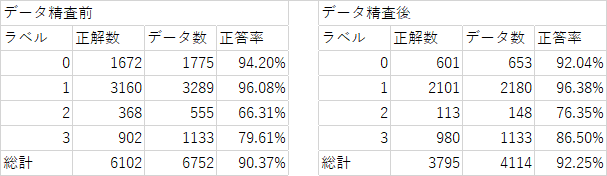

カテゴリ２と３で大幅な精度向上となりました。

## sentence-BERT

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 1.1MB 7.1MB/s 
     |████████████████████████████████| 3.0MB 15.1MB/s 
     |████████████████████████████████| 1.1MB 32.9MB/s 
     |████████████████████████████████| 890kB 58.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.7.2-cp36-none-any.whl size=91190 sha256=4e804fd46b3d640bd9c470125d77ef75657356f4f390e8e40afcac2b9d7f41b2
  Stored in directory: /root/.cache/pip/wheels/4b/8f/23/7f93e91176acc7c2d651b54fa9f01e3624a47904145c4d133e
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=70d1f0746b5cd205b2696282e61488eef28fd3e105ef32f79984f502c2c9ad0c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
!apt-get install mecab mecab-ipadic-utf8 python-mecab libmecab-dev
!pip install mecab-python3
!pip install ipadic
!pip install fugashi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-jumandic mecab-jumandic-utf8 mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-jumandic
  mecab-jumandic-utf8 mecab-utils python-mecab
0 upgraded, 9 newly installed, 0 to remove and 21 not upgraded.
Need to get 29.0 MB of archives.
After this operation, 277 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmecab2 amd64 0.996-5 [257 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmecab-dev amd64 0.996-5 [308 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 mecab-utils amd64 0.996-5 [4,856 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 mecab-jumandic-utf8 all 7.0-20130310-4 [16.2 MB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/

In [ ]:
import transformers
transformers.BertTokenizer = transformers.BertJapaneseTokenizer
from sentence_transformers import SentenceTransformer
from sentence_transformers import models

transformer = models.BERT('cl-tohoku/bert-base-japanese-whole-word-masking')
pooling = models.Pooling(transformer.get_word_embedding_dimension(), pooling_mode_mean_tokens=True, pooling_mode_cls_token=False, pooling_mode_max_tokens=False)
stBERTmodel = SentenceTransformer(modules=[transformer, pooling])

sentences = ['吾輩は猫である',  '本日は晴天なり']
embeddings = stBERTmodel.encode(sentences)

for i, embedding in enumerate(embeddings):
  print("[%d] : %s" % (i, embedding.shape, ))


[0] : (768,)
[1] : (768,)


### 全結合層4値分類タスク

In [ ]:
# 文書ベクトルの作成

import numpy as np
texts = np.load('data/改mecab_data.npy')
texts = [s.replace(' ', '') for s in texts.tolist()]

def sentBERTtovec(texts):
 return  stBERTmodel.encode(texts)

x_ = sentBERTtovec(texts)
x_ = csr_matrix(x_)
texts[:5], x_.todense()

(['第１の液体を基材表面に付与されてなる第１液層を形成する工程と、前記第１液層が形成された前記基材表面に、前記第１の液体とは非相溶であり、かつ、前記第１の液体よりも比重が大きい第２の液体の液滴をインクジェット法で付与する工程と、前記第１の液体および第２の液体の一方の液体を選択的に硬化させる工程と、を有する、パターン形成方法。インクジェット法により基材表面に付与された液体が硬化して形成されたパターン形成物であって、前記液体の硬化物により形成されるパターンが有する前記基材表面に接する壁面と、前記基材表面と、の間の角度は、４５°以上である、パターン形成物。第１の液体を基材表面に付与する第１液体付与部と、前記第１の液体が付与された前記基材表面に、前記第１の液体とは非相溶であり、かつ、前記第１の液体よりも比重が大きい第２の液体の液滴をインクジェット法で付与する第２液体付与部と、前記第１の液体および第２の液体の一方の液体を選択的に硬化させる選択的硬化部と、を有する、パターン形成装置。\n',
  '２種以上の金属によって構成される導電性細線によって構成される、１０００ｃｍ２以上の面積にわたる導電性細線パターンの製造方法であって、基材上に第１の金属によって構成された第１の導電性細線をパターニングし、次いで、前記第１の導電性細線に、前記第１の金属とは異なる金属種である第２の金属によって構成された導電性皮膜を被覆する被覆処理を施して、前記第１の導電性細線と前記導電性皮膜とによって構成された第２の導電性細線を形成し、次いで、前記第２の導電性細線に、該第２の導電性細線の線幅の減少速度が０．５μｍ／ｍｉｎ以下となるエッチングを施して、前記第２の導電性細線を構成する前記導電性皮膜の一部が除去された第３の導電性細線を形成することを特徴とする導電性細線パターンの製造方法。\n',
  '染色液によるメディアへの着色度合を調整する単独では前記メディア上で視認困難な染色調整剤と、色材とを含有する染色調整インクを前記メディアにインクジェット方式により塗布する塗布工程と、前記染色調整インクが塗布された前記メディアを前記染色液に浸漬して染色する染色工程と、を備える、染色物の製造方法。染色液によるメディアへの着色度合を調整する単独では前記メディア上で視認困難な染色調整剤と、前記染色液による染色工程で視認で

学習4回目


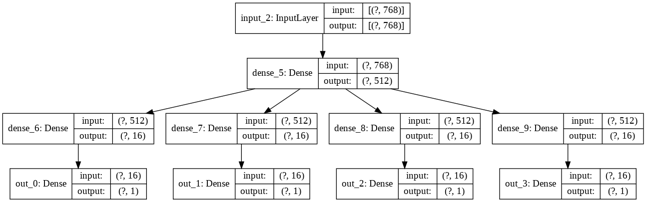

Epoch 1/4
65/65 [==============================] - 1s 11ms/step - loss: 0.3749 - out_0_loss: 0.0785 - out_1_loss: 0.1046 - out_2_loss: 0.0462 - out_3_loss: 0.1456 - out_0_acc: 0.8829 - out_1_acc: 0.8605 - out_2_acc: 0.9456 - out_3_acc: 0.7872 - val_loss: 0.2667 - val_out_0_loss: 0.0440 - val_out_1_loss: 0.0842 - val_out_2_loss: 0.0327 - val_out_3_loss: 0.1058 - val_out_0_acc: 0.9339 - val_out_1_acc: 0.8930 - val_out_2_acc: 0.9669 - val_out_3_acc: 0.8589
Epoch 2/4
65/65 [==============================] - 0s 7ms/step - loss: 0.2549 - out_0_loss: 0.0417 - out_1_loss: 0.0719 - out_2_loss: 0.0369 - out_3_loss: 0.1043 - out_0_acc: 0.9427 - out_1_acc: 0.9057 - out_2_acc: 0.9611 - out_3_acc: 0.8581 - val_loss: 0.2337 - val_out_0_loss: 0.0376 - val_out_1_loss: 0.0700 - val_out_2_loss: 0.0280 - val_out_3_loss: 0.0980 - val_out_0_acc: 0.9475 - val_out_1_acc: 0.9056 - val_out_2_acc: 0.9669 - val_out_3_acc: 0.8638
Epoch 3/4
65/65 [==============================] - 0s 7ms/step - loss: 0.2199 - out_0

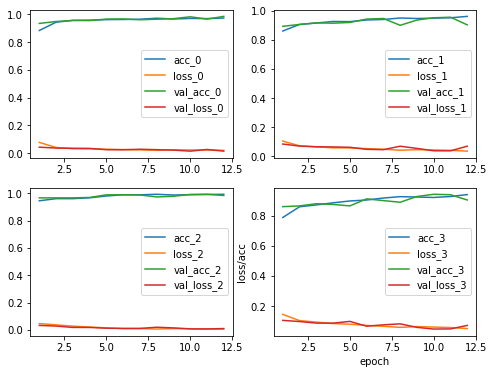

推論4回目
33/33 [==============================] - 0s 2ms/step
未知データ推論，正答率：86.479%

acc平均: 88.406%


In [ ]:
# 交差検証の工夫で用いたプログラムを変更なしに使います
# 定数
index_cycle = [[[[1, 2], 0, 3], [[0, 2], 1, 3], [[0, 1], 2, 3]], 
               [[[2, 3], 1, 0], [[1, 3], 2, 0], [[1, 2], 3, 0]], 
               [[[2, 3], 0, 1], [[0, 3], 2, 1], [[0, 2], 3, 1]], 
               [[[1, 3], 0, 2], [[0, 3], 1, 2], [[0, 1], 3, 2]]
               ]
loss, optimizer, metrics = ['mean_squared_error', 'Adam', 'acc']
batch_size = 32
epochs = 4
coef = 0.5
Trsld = 0.5

ref = [[], [], []]
result = []
for i, cond in enumerate(index_cycle):
  initial_epoch = 0
  clear_output()
  print('学習{}回目'.format(i+1))
  model = DrctIn_Dense_4pthOut(x_, i)
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  for j, [train_, valid_, test_] in enumerate(cond):
    train_index = np.hstack([div_index[train_[0]], div_index[train_[1]]])
    x_train = x_[train_index].todense()
    y_train = y_4[train_index]
    valid_index = div_index[valid_]
    x_valid = x_[valid_index].todense()
    y_valid = y_4[valid_index]
    test_index = div_index[test_]
    x_test = x_[test_index].todense()
    y_test = y_4[test_index]

    # 学習
    temp = model.fit(x_train, {'out_0':y_train[:,0], 'out_1':y_train[:,1], 
                                  'out_2':y_train[:,2], 'out_3':y_train[:,3]}, 
                        batch_size=batch_size, 
                        initial_epoch=initial_epoch, epochs=initial_epoch+epochs, verbose=1, 
                        validation_data=(x_valid, {'out_0':y_valid[:,0], 'out_1':y_valid[:,1], 
                                                    'out_2':y_valid[:,2], 'out_3':y_valid[:,3]}))
    if j == 0: 
      training = temp
    else:
      training.history['loss'] += temp.history['loss']
      training.history['val_loss'] += temp.history['val_loss']
      training.history['out_0_acc'] += temp.history['out_0_acc']
      training.history['out_0_loss'] += temp.history['out_0_loss']
      training.history['val_out_0_acc'] += temp.history['val_out_0_acc']
      training.history['val_out_0_loss'] += temp.history['val_out_0_loss']
      training.history['out_1_acc'] += temp.history['out_1_acc']
      training.history['out_1_loss'] += temp.history['out_1_loss']
      training.history['val_out_1_acc'] += temp.history['val_out_1_acc']
      training.history['val_out_1_loss'] += temp.history['val_out_1_loss']
      training.history['out_2_acc'] += temp.history['out_2_acc']
      training.history['out_2_loss'] += temp.history['out_2_loss']
      training.history['val_out_2_acc'] += temp.history['val_out_2_acc']
      training.history['val_out_2_loss'] += temp.history['val_out_2_loss']
      training.history['out_3_acc'] += temp.history['out_3_acc']
      training.history['out_3_loss'] += temp.history['out_3_loss']
      training.history['val_out_3_acc'] += temp.history['val_out_3_acc']
      training.history['val_out_3_loss'] += temp.history['val_out_3_loss']
    initial_epoch += epochs
  # 学習曲線のプロット
  plot_quad_history(training)
  # 未知データを入力して正答率を求める
  print('推論{}回目'.format(i+1))
  pred_data = model.predict(x_test, batch_size=batch_size, verbose=1, steps=None)
  # Tensorflow graphの消去
  tf.keras.backend.clear_session()
  pred_data = np.argmax(np.hstack(pred_data), axis=1)
  y_test = np.argmax(y_test, axis=1)
  accuracy = accuracy_score(pred_data, y_test)
  result.append(accuracy)
  print('未知データ推論，正答率：{0:.3%}\n'.format(accuracy))
  ref[0] += test_index.tolist()
  ref[1] += pred_data.tolist()
  ref[2] += y_test.tolist()

print('acc平均: {0:.3%}'.format(sum(result)/len(result)))
# 各カテゴリの正答率をExcelとして出力
pd.DataFrame(ref).T.to_excel('data/ref改.xlsx', header=None, index=None)